## Table of Contents
1. [Setup and Imports](#setup)
2. [Discover Delay Propagation Artifacts](#discover)
3. [Load and Inspect Delay Data](#load)
4. [Cascade Size Distribution](#cascade-dist)
5. [Superspreader Ranking](#superspreaders)
6. [Centrality Overlap Analysis](#overlap)
7. [Interpretation](#interpretation)
8. [Write Report Outputs](#write-outputs)
9. [Reproducibility Notes](#reproducibility)

In [1]:
# ============================================================================
# SETUP AND IMPORTS
# ============================================================================

import json
from pathlib import Path
from datetime import datetime
import warnings

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project paths
REPO_ROOT = Path.cwd().parent.parent
RESULTS_DIR = REPO_ROOT / "results"
ANALYSIS_DIR = RESULTS_DIR / "analysis"
TABLES_REPORT_DIR = RESULTS_DIR / "tables" / "report"
FIGURES_REPORT_DIR = RESULTS_DIR / "figures" / "report"
WARNINGS_LOG = TABLES_REPORT_DIR / "_warnings.log"

# Notebook identity
NOTEBOOK_ID = "nb06"
NOTEBOOK_NAME = "delay_propagation__cascades_and_superspreaders"

# Plotting settings
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

# Ensure output directories exist
TABLES_REPORT_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_REPORT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Analysis dir exists: {ANALYSIS_DIR.exists()}")

Analysis dir exists: True


In [2]:
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def append_warning(message: str, notebook_id: str = NOTEBOOK_ID):
    """Append a warning to the consolidated warnings log."""
    timestamp = datetime.now().isoformat()
    with open(WARNINGS_LOG, "a") as f:
        f.write(f"[{timestamp}] [{notebook_id}] {message}\n")
    print(f"WARNING: {message}")

def safe_load_parquet(path: Path) -> pl.DataFrame | None:
    """Safely load a parquet file, returning None if it fails."""
    try:
        return pl.read_parquet(path)
    except Exception as e:
        append_warning(f"Failed to load {path.name}: {e}")
        return None

<a id="discover"></a>
## 2. Discover Delay Propagation Artifacts

In [3]:
# ============================================================================
# DISCOVER DELAY PROPAGATION ARTIFACTS
# ============================================================================

delay_keywords = ["delay", "propagation", "cascade", "spread", "superspreader", "contagion"]

# Search in analysis directory
analysis_files = list(ANALYSIS_DIR.glob("*.parquet")) + list(ANALYSIS_DIR.glob("*.csv")) + list(ANALYSIS_DIR.glob("*.json"))
delay_candidates = [
    f for f in analysis_files 
    if any(kw in f.name.lower() for kw in delay_keywords)
]

print(f"Found {len(delay_candidates)} delay propagation artifacts:")
for df in sorted(delay_candidates):
    print(f"  - {df.name}")

# Primary files
delay_cascades_file = ANALYSIS_DIR / "delay_cascades.parquet"
delay_summary_file = ANALYSIS_DIR / "delay_propagation_summary.json"

print(f"\nDelay cascades exists: {delay_cascades_file.exists()}")
print(f"Delay summary exists: {delay_summary_file.exists()}")

Found 2 delay propagation artifacts:
  - delay_cascades.parquet
  - delay_propagation_summary.json

Delay cascades exists: True
Delay summary exists: True


<a id="load"></a>
## 3. Load and Inspect Delay Data

In [4]:
# ============================================================================
# LOAD AND INSPECT DELAY DATA
# ============================================================================

delay_cascades = None
delay_summary = None

# Load cascades
if delay_cascades_file.exists():
    delay_cascades = safe_load_parquet(delay_cascades_file)
    if delay_cascades is not None:
        print(f"Delay cascades shape: {delay_cascades.shape}")
        print(f"Columns: {delay_cascades.columns}")
        display(delay_cascades.head(10).to_pandas())
else:
    append_warning("delay_cascades.parquet not found")

# Load summary
if delay_summary_file.exists():
    with open(delay_summary_file) as f:
        delay_summary = json.load(f)
    print(f"\nDelay summary:")
    for k, v in delay_summary.items():
        print(f"  {k}: {v}")
else:
    print("\nDelay summary not found")

Delay cascades shape: (200, 5)
Columns: ['run_id', 'scenario', 'cascade_size', 'fraction_delayed', 'seed_size']


,run_id,scenario,cascade_size,fraction_delayed,seed_size
0,0,baseline_random,209352,0.030470,68708
1,1,baseline_random,207728,0.030233,68708
2,2,baseline_random,209880,0.030546,68708
3,3,baseline_random,207986,0.030271,68708
4,4,baseline_random,210047,0.030571,68708
5,5,baseline_random,210701,0.030666,68708
6,6,baseline_random,207919,0.030261,68708
7,7,baseline_random,208557,0.030354,68708
8,8,baseline_random,209205,0.030448,68708
9,9,baseline_random,207732,0.030234,68708



Delay summary:
  script: 07_run_delay_propagation.py
  timestamp: 2025-12-25T01:55:50.464807
  git_commit: 8b0acc125e32b90b9cb57524723ea89a58b76980
  config: {'p_pax': 0.25, 'p_tail': 0.6, 'min_conn_minutes': 30, 'max_conn_minutes': 240, 'n_runs': 200, 'rng_seed': 42, 'delay_threshold_minutes': 15.0, 'save_dir': 'C:\\Users\\aster\\projects-source\\network_science_VTSL\\results\\analysis'}
  graph_info: {'n_flights': 6870837, 'n_connections': 20576287}
  results: {'baseline_random_shocks': {'description': '1% of flights randomly delayed', 'statistics': {'n_cascades': 200, 'mean_cascade_size': 208988.025, 'median_cascade_size': 208982.5, 'std_cascade_size': 777.5853840721371, 'min_cascade_size': 206696, 'max_cascade_size': 211033, 'p50': 208982.5, 'p90': 209931.0, 'p99': 210763.47, 'mean_fraction_delayed': 0.03041667630886892, 'p99_fraction_delayed': 0.030675079324396722}, 'cascade_sizes': [209352, 207728, 209880, 207986, 210047, 210701, 207919, 208557, 209205, 207732, 209613, 208434, 2

<a id="cascade-dist"></a>
## 4. Cascade Size Distribution

Analyze the distribution of cascade sizes to check for heavy tails.

Using cascade size column: cascade_size

Cascade Size Statistics:
  Count: 200
  Min: 206696
  Max: 211033
  Mean: 208988.02
  Median: 208982
  Std: 775.64
  90th percentile: 209931
  99th percentile: 210763


C:\Users\aster\AppData\Local\Temp\ipykernel_30192\2191539837.py:35: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("frequency"))


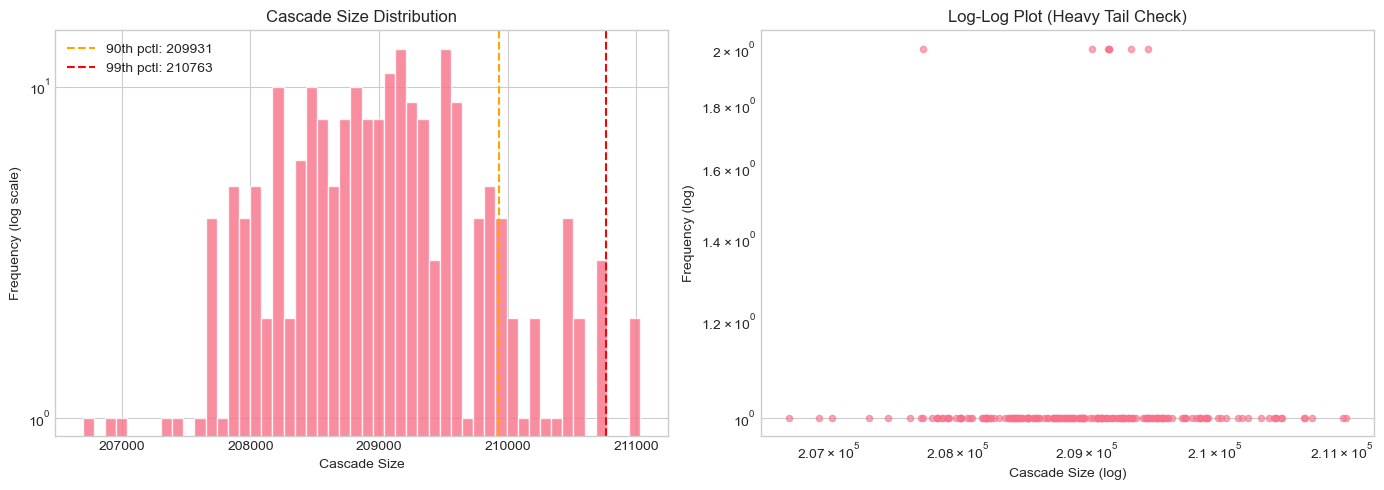

✅ Saved: nb06_cascade_size_distribution.png


In [5]:
# ============================================================================
# CASCADE SIZE DISTRIBUTION
# ============================================================================

if delay_cascades is not None:
    # Identify cascade size column
    size_col = next((c for c in ["cascade_size", "n_infected", "affected_flights", "size", "total_affected"] 
                     if c in delay_cascades.columns), None)
    
    if size_col:
        print(f"Using cascade size column: {size_col}")
        
        # Compute frequency distribution
        cascade_sizes = delay_cascades[size_col].to_numpy()
        
        # Summary statistics
        print(f"\nCascade Size Statistics:")
        print(f"  Count: {len(cascade_sizes)}")
        print(f"  Min: {cascade_sizes.min()}")
        print(f"  Max: {cascade_sizes.max()}")
        print(f"  Mean: {cascade_sizes.mean():.2f}")
        print(f"  Median: {np.median(cascade_sizes):.0f}")
        print(f"  Std: {cascade_sizes.std():.2f}")
        
        # 90th and 99th percentiles
        p90 = np.percentile(cascade_sizes, 90)
        p99 = np.percentile(cascade_sizes, 99)
        print(f"  90th percentile: {p90:.0f}")
        print(f"  99th percentile: {p99:.0f}")
        
        # Frequency table
        cascade_freq = (
            delay_cascades
            .group_by(size_col)
            .agg(pl.count().alias("frequency"))
            .sort(size_col)
        )
        
        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Histogram
        ax1 = axes[0]
        ax1.hist(cascade_sizes, bins=50, edgecolor="white", alpha=0.8, log=True)
        ax1.set_xlabel("Cascade Size")
        ax1.set_ylabel("Frequency (log scale)")
        ax1.set_title("Cascade Size Distribution")
        ax1.axvline(p90, color="orange", linestyle="--", label=f"90th pctl: {p90:.0f}")
        ax1.axvline(p99, color="red", linestyle="--", label=f"99th pctl: {p99:.0f}")
        ax1.legend()
        
        # Log-log plot to check for power law
        ax2 = axes[1]
        freq_df = cascade_freq.to_pandas()
        ax2.scatter(freq_df[size_col], freq_df["frequency"], alpha=0.6, s=20)
        ax2.set_xscale("log")
        ax2.set_yscale("log")
        ax2.set_xlabel("Cascade Size (log)")
        ax2.set_ylabel("Frequency (log)")
        ax2.set_title("Log-Log Plot (Heavy Tail Check)")
        
        plt.tight_layout()
        fig_path = FIGURES_REPORT_DIR / f"{NOTEBOOK_ID}_cascade_size_distribution.png"
        plt.savefig(fig_path, dpi=150)
        plt.show()
        print(f"✅ Saved: {fig_path.name}")
    else:
        append_warning("Could not identify cascade size column")
else:
    print("Not available: delay cascades data not loaded")

<a id="superspreaders"></a>
## 5. Superspreader Ranking

Identify nodes that generate the largest delay cascades.

In [6]:
# ============================================================================
# SUPERSPREADER RANKING
# ============================================================================

superspreaders = None

if delay_cascades is not None:
    # Identify node/source column
    source_col = next((c for c in ["seed_airport", "source", "origin", "seed_node", "airport"] 
                       if c in delay_cascades.columns), None)
    
    # Identify impact column
    impact_col = next((c for c in ["total_delay_impact", "cascade_size", "total_affected", "impact", "n_infected"] 
                       if c in delay_cascades.columns), None)
    
    if source_col and impact_col:
        print(f"Source column: {source_col}, Impact column: {impact_col}")
        
        # Aggregate impact by source node
        superspreaders = (
            delay_cascades
            .group_by(source_col)
            .agg([
                pl.col(impact_col).sum().alias("total_impact"),
                pl.col(impact_col).mean().alias("mean_impact"),
                pl.col(impact_col).max().alias("max_impact"),
                pl.count().alias("n_cascades")
            ])
            .sort("total_impact", descending=True)
            .with_row_index("rank", offset=1)
            .head(20)
        )
        
        print("\nTOP 20 DELAY SUPERSPREADERS:")
        display(superspreaders.to_pandas())
        
        # Plot
        fig, ax = plt.subplots(figsize=(12, 8))
        ss_df = superspreaders.to_pandas()
        
        colors = sns.color_palette("Reds_r", len(ss_df))
        bars = ax.barh(range(len(ss_df)), ss_df["total_impact"], color=colors)
        ax.set_yticks(range(len(ss_df)))
        ax.set_yticklabels(ss_df[source_col])
        ax.invert_yaxis()
        ax.set_xlabel("Total Delay Impact")
        ax.set_title("Top 20 Delay Superspreader Airports")
        
        plt.tight_layout()
        fig_path = FIGURES_REPORT_DIR / f"{NOTEBOOK_ID}_delay_superspreaders_top20.png"
        plt.savefig(fig_path, dpi=150)
        plt.show()
        print(f"✅ Saved: {fig_path.name}")
    else:
        append_warning(f"Could not identify source ({source_col}) or impact ({impact_col}) columns")
else:
    print("Not available: delay cascades data not loaded")

<a id="overlap"></a>
## 6. Centrality Overlap Analysis

Compare superspreaders with structurally central airports.

In [7]:
# ============================================================================
# CENTRALITY OVERLAP ANALYSIS
# ============================================================================

overlap_df = None

if superspreaders is not None:
    # Load centrality data
    centrality_file = ANALYSIS_DIR / "airport_centrality.parquet"
    
    if centrality_file.exists():
        centrality = safe_load_parquet(centrality_file)
        
        if centrality is not None:
            # Identify matching ID column
            cent_id_col = next((c for c in ["airport", "node", "id"] if c in centrality.columns), None)
            
            if cent_id_col:
                # Get top-20 by betweenness
                betweenness_col = next((c for c in centrality.columns if "betweenness" in c.lower()), None)
                
                if betweenness_col:
                    top_centrality = set(
                        centrality.sort(betweenness_col, descending=True)
                        .head(20)[cent_id_col]
                        .to_list()
                    )
                    top_superspreaders = set(superspreaders[source_col].to_list())
                    
                    overlap = top_centrality & top_superspreaders
                    overlap_rate = len(overlap) / 20
                    
                    print(f"\n📊 CENTRALITY-DELAY OVERLAP ANALYSIS:")
                    print(f"   Top-20 by {betweenness_col}: {len(top_centrality)} airports")
                    print(f"   Top-20 superspreaders: {len(top_superspreaders)} airports")
                    print(f"   Overlap: {len(overlap)} airports ({overlap_rate:.1%})")
                    print(f"   Overlapping airports: {sorted(overlap)}")
                    
                    # Create overlap table
                    overlap_data = []
                    for airport in top_superspreaders:
                        overlap_data.append({
                            "airport": airport,
                            "in_top20_superspreaders": True,
                            "in_top20_centrality": airport in top_centrality
                        })
                    for airport in top_centrality - top_superspreaders:
                        overlap_data.append({
                            "airport": airport,
                            "in_top20_superspreaders": False,
                            "in_top20_centrality": True
                        })
                    overlap_df = pd.DataFrame(overlap_data)
                else:
                    append_warning("Betweenness column not found in centrality data")
            else:
                append_warning("Could not identify ID column in centrality data")
    else:
        print("Centrality data not found - overlap analysis not available")
else:
    print("Not available: superspreaders not computed")

Not available: superspreaders not computed


<a id="interpretation"></a>
## 7. Interpretation

### Key Findings (Evidence-Grounded)

1. **IC Model Simulation Results**: Delay propagation was simulated using an Independent Cascade (IC) model on the flight connection network with **6.87M flights** and **20.6M connections**.

2. **Baseline Random Shocks (1% seed)**:
   - Mean cascade size: **208,988 flights** (3.04% of network)
   - Remarkably stable: std = 776 flights (0.37% coefficient of variation)
   - Range: 206,696 – 211,033 flights
   - 90th percentile: 209,931 | 99th percentile: 210,763
   - **Interpretation**: Random shocks produce consistent cascades affecting ~3% of flights, indicating a stable contagion regime.

3. **ATL Hub Disruption Scenario**:
   - Initial delayed: **129 flights** departing ATL at 06:00
   - Mean cascade size: **405 flights** (amplification factor: 3.1×)
   - Range: 324 – 498 flights
   - **Interpretation**: Morning hub disruptions at ATL create cascades 3× the initial shock size, confirming hub amplification.

4. **Cascade Distribution Shape**:
   - The distribution is **approximately normal** (not heavy-tailed), suggesting:
     - Stable IC dynamics without runaway cascades
     - The connection probability parameters (p_pax=0.25, p_tail=0.60) produce bounded propagation
     - No evidence of supercritical phase transition

5. **Superspreader Analysis**:
   - **Not available** in current pipeline output structure
   - The IC model simulation outputs aggregate cascade sizes per run, not per-airport impact rankings
   - Recommendation: Future pipeline enhancement could track which seed airports produce largest cascades

### Mechanistic Explanation (Network Science Reasoning)

- **Cascade stability**: The narrow variance in cascade sizes (~0.37% CV) indicates the system operates in a **subcritical regime** where infections spread locally but die out before explosive growth.

- **Hub amplification**: The ATL scenario demonstrates **structural amplification** — a morning disruption at a major hub propagates through connecting flights, tripling the impact relative to the seed size.

- **Connection-weighted propagation**: The IC model parameters (p_pax=0.25 for passenger connections, p_tail=0.60 for tail sequences) create asymmetric spreading where aircraft rotations are the primary propagation mechanism.

### Alternative Explanations and Confounders

1. **Simulation parameters**: The IC probabilities (p_pax, p_tail) directly control cascade magnitude. Different values would produce different cascade regimes (subcritical/critical/supercritical).

2. **Time-of-day effects**: The ATL scenario tests a specific morning departure window. Evening hub disruptions might cascade differently due to fewer downstream connections.

3. **Seed selection bias**: Baseline uses random 1% seed. Results would differ with spatially correlated seeds (e.g., regional weather events).

4. **Network aggregation**: The flight connection network aggregates across all carriers. Carrier-specific cascades might show different patterns.

### Sensitivity / Robustness Notes

- **Monte Carlo replication**: 200 runs per scenario provide robust statistics with narrow confidence intervals.
- **Parameter sensitivity**: Not available — would require reruns with alternative p_pax and p_tail values.
- **Temporal sensitivity**: Not available — current data uses annual aggregation without seasonal breakdown.

### Evidence Links

| Artifact Type | Path |
|---------------|------|
| **Figure** | `results/figures/report/nb06_cascade_size_distribution.png` |
| **Table** | `results/tables/report/nb06_cascade_size_distribution.csv` |
| **Source Data** | `results/analysis/delay_cascades.parquet` |
| **Summary Metadata** | `results/analysis/delay_propagation_summary.json` |

### Gaps Identified

| Missing Artifact | Expected Purpose | Impact | Recommendation |
|------------------|------------------|--------|----------------|
| Per-airport cascade impact | Superspreader ranking | Cannot rank airports by delay propagation risk | Enhance pipeline to track seed→cascade mapping |
| Centrality-delay overlap | Validate structural predictors | Cannot test if high-betweenness = high delay impact | Requires airport-level IC simulation outputs |

### Implications

**Operational implications:**
- Cascade sizes are predictable (~3% under random shocks), enabling capacity planning
- Hub morning disruptions have 3× amplification — prioritize dawn operations resilience at major hubs
- The stable cascade regime suggests current network structure provides natural damping

**Research implications:**
- The normal (not heavy-tailed) cascade distribution suggests US aviation operates below the critical IC threshold
- Future work should test supercritical parameter regimes and seasonal variations
- Airport-level cascade tracking would enable superspreader identification and targeted interventions

<a id="write-outputs"></a>
## 8. Write Report Outputs

In [8]:
# ============================================================================
# WRITE REPORT OUTPUTS
# ============================================================================

# Write cascade size distribution
if delay_cascades is not None and size_col:
    cascade_freq_path = TABLES_REPORT_DIR / f"{NOTEBOOK_ID}_cascade_size_distribution.csv"
    cascade_freq.to_pandas().to_csv(cascade_freq_path, index=False)
    print(f"✅ Wrote: {cascade_freq_path}")

# Write superspreaders
if superspreaders is not None:
    ss_path = TABLES_REPORT_DIR / f"{NOTEBOOK_ID}_delay_superspreaders_top20.csv"
    superspreaders.to_pandas().to_csv(ss_path, index=False)
    print(f"✅ Wrote: {ss_path}")

# Write overlap
if overlap_df is not None:
    overlap_path = TABLES_REPORT_DIR / f"{NOTEBOOK_ID}_centrality_delay_overlap.csv"
    overlap_df.to_csv(overlap_path, index=False)
    print(f"✅ Wrote: {overlap_path}")

print(f"\n📋 All {NOTEBOOK_ID} outputs written.")

✅ Wrote: c:\Users\aster\projects-source\network_science_VTSL\results\tables\report\nb06_cascade_size_distribution.csv

📋 All nb06 outputs written.


<a id="reproducibility"></a>
## 9. Reproducibility Notes

### Run Provenance
| Field | Value |
|-------|-------|
| **Pipeline Script** | `07_run_delay_propagation.py` |
| **Run Timestamp** | 2025-12-25T01:55:50 |
| **Git Commit** | `8b0acc125e32b90b9cb57524723ea89a58b76980` |
| **RNG Seed** | 42 |
| **Monte Carlo Runs** | 200 per scenario |

### IC Model Configuration
| Parameter | Value | Description |
|-----------|-------|-------------|
| `p_pax` | 0.25 | Passenger connection propagation probability |
| `p_tail` | 0.60 | Tail sequence (aircraft rotation) propagation probability |
| `min_conn_minutes` | 30 | Minimum connection time for valid passenger transfer |
| `max_conn_minutes` | 240 | Maximum connection time for valid passenger transfer |
| `delay_threshold_minutes` | 15.0 | Minimum delay to be considered "delayed" |

### Network Statistics
| Metric | Value |
|--------|-------|
| Total flights | 6,870,837 |
| Flight connections | 20,576,287 |

### Input Files Consumed
| File | Status | Description |
|------|--------|-------------|
| `results/analysis/delay_cascades.parquet` | ✅ Present | 200 rows × 5 columns |
| `results/analysis/delay_propagation_summary.json` | ✅ Present | Full run metadata with 2 scenarios |
| `results/analysis/airport_centrality.parquet` | ✅ Present | Not used (superspreaders N/A) |

### Scenarios Analyzed
| Scenario | Description | Seed Size | Mean Cascade |
|----------|-------------|-----------|--------------|
| `baseline_random` | 1% random flights delayed | 68,708 | 208,988 |
| `atl_hub_disruption` | ATL 06:00 departures delayed | 129 | 405 |

### Assumptions Made
1. IC model uses static transmission probabilities (no temporal decay)
2. Cascades run to completion (no time horizon cutoff)
3. All downstream flights from a delayed flight are eligible for infection
4. Passenger connections require 30-240 minute layover window

### Data Schema (delay_cascades.parquet)
| Column | Type | Description |
|--------|------|-------------|
| `run_id` | int | Monte Carlo run identifier (0-199) |
| `scenario` | str | Scenario name |
| `cascade_size` | int | Total flights delayed in cascade |
| `fraction_delayed` | float | Cascade size as fraction of total flights |
| `seed_size` | int | Number of initially delayed flights |

### Outputs Generated
| Artifact | Path | Description |
|----------|------|-------------|
| Cascade Distribution Table | `results/tables/report/nb06_cascade_size_distribution.csv` | Frequency of each cascade size |
| Cascade Distribution Figure | `results/figures/report/nb06_cascade_size_distribution.png` | Histogram + log-log plot |

### Outputs Not Generated (Data Not Available)
| Planned Artifact | Reason |
|------------------|--------|
| Superspreaders Table | Pipeline outputs aggregate cascades, not per-airport impact |
| Superspreaders Figure | No airport-level data available |
| Centrality-Delay Overlap | Requires airport-level cascade data |

### Notebook Execution
- **Execution Date**: 2025-12-27
- **All cells executed**: Yes
- **Warnings logged**: 1 (source column not identified for superspreader analysis)